## 4. Сегментация изображений городских сцен (датасет CamVid)

---

По материалам курсов https://course.fast.ai/

*переведено, дополнено, адаптировано, расширено https://vk.com/lambda_brain*
*январь 2020*

---


Сегментация изображения -- это разбиение цифрового изображения на множество областей, сегментов (или иногда контуров). Каждый сегмент -- это набор пикселов одного цвета, который выделяет в изображении некоторый отдельный объект (например, пешеход, кот, автомобиль), точнее, класс объектов (выделение объектов внутри своего класса -- это отдельная задача). Однако и такой подход существено упрощает дальнейшую обработку изображения на более высоком уровне абстракции.

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

**CamVid** (The Cambridge-driving Labeled Video Database) -- это один из стандартных датасетов, поддерживаемый **fast.ai**. В нём собрано 701 изображение, точнее, 701 HD-кадр из видезаписей с позиции водителя. Кадры отобраны из пяти двухминутных видео во время экспериментов с тестовым беспилотным автомобилем в городских условиях.
Каждый пиксел каждого изображения размечен и относится к одному из 32 классов.

In [0]:
# стандартные подключения
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *

In [0]:
colab_path = "/content/sample_data/" # более удобный каталог для данных в google.colab
path = untar_data(URLs.CAMVID, dest=colab_path) # загружаем и распаковываем оригинальный датасет
path.ls()

In [0]:
path_lbl = path/'labels' # путь к разметке
path_img = path/'images' # путь к изображениям
path_img


## Исходные данные

Список всех классов хранится в корневом каталоге датасета, в файле codes.txt.

In [0]:
codes = np.loadtxt(path/'codes.txt', dtype=str); codes # каждому цвету в файле маски соответствует свой класс

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car', 'CartLuggagePram', 'Child', 'Column_Pole',
       'Fence', 'LaneMkgsDriv', 'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving', 'ParkingBlock',
       'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk', 'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel', 'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

In [0]:
fnames = get_image_files(path_img) # список всех файлов изображений
fnames[:3]

In [0]:
lbl_names = get_image_files(path_lbl) # список всех файлов масок
lbl_names[:3]

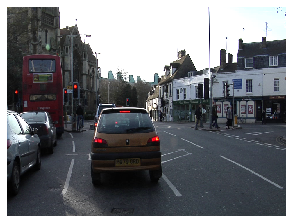

In [0]:
img_f = fnames[0] # возьмём первое изображение
img = open_image(img_f)
img.show(figsize=(5,5))

In [0]:
get_y_fn = lambda x: path_lbl/f'{x.stem}_P{x.suffix}' # функция формирует имя файла маски по имени файла изображения

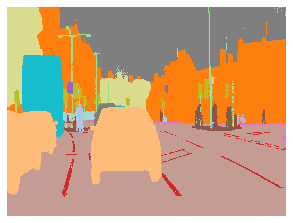

In [0]:
mask = open_mask(get_y_fn(img_f)) # вытащим маску, соответствующую текущему изображению
mask.show(figsize=(5,5), alpha=1)

In [0]:
src_size = np.array(mask.shape[1:]) # размер и содержимое маски
src_size,mask.data

## Датасет

Датасет с поддержкой сегментации в **fast.ai** называется **датабанч (databunch)**.

In [0]:
size = src_size // 2 # изображения уменьшим в два раза

free = gpu_mem_get_free_no_cache()
# определяем размер batch size, bs
# в зависимости от доступной оперативки графического процессора

# bs -- количество изображений, обрабатываемых за одну итерацию, за одно обновление параметров алгоритма
# когда bs = размеру датасета, количество итераций = количеству эпох

if free > 8200: bs=8
else:           bs=4
print(f"получаем bs={bs}, доступно {free}MB из GPU RAM")

In [0]:
# для формирования датасета с поддержкой сегментации используем класс SegmentationItemList
src = (SegmentationItemList.from_folder(path_img) # грузим исходные данные
       .split_by_fname_file('../valid.txt') # разбиваем данные на обучающую и тестовую выборки 
       .label_from_func(get_y_fn, classes=codes)) # разметку данных получаем с помощью get_y_fn

In [0]:
data = (src.transform(get_transforms(), size=size, tfm_y=True) # поворачиваем изображения горизонтально
        #  tfm_y=True потому что для масок нужно такое же преобразование, которое применялось и к оригинальным изображениям

        .databunch(bs=bs) # создаём датасет 
        .normalize(imagenet_stats)) # нормализуем для модели resnet

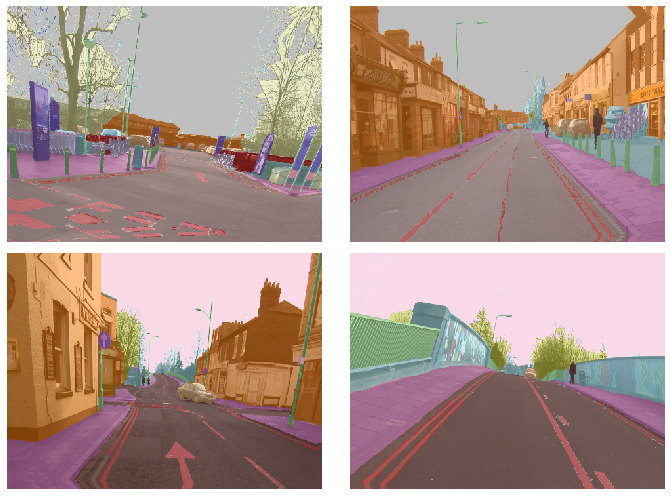

In [0]:
data.show_batch(2, figsize=(10,7)) # show_batch -- стандартный метод для работы с любыми датабанчами fast.ai

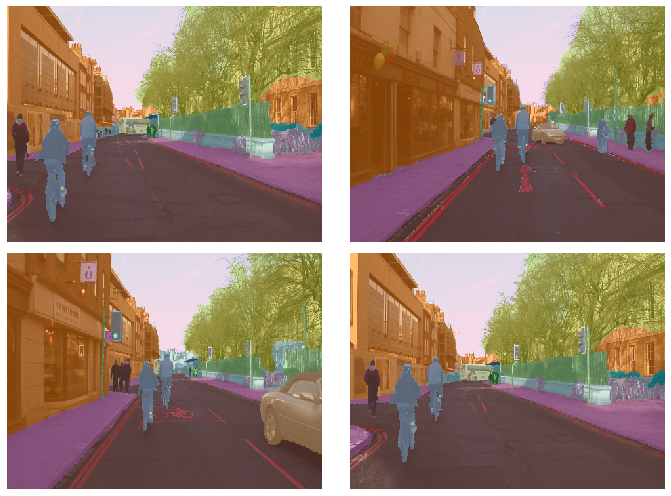

In [0]:
data.show_batch(2, figsize=(10,7), ds_type=DatasetType.Valid) # примеры из тестовой выборки

## Модель

Перед обращением к модели сегментации надо создать функцию, которая будет измерять точность модели -- количество корректно классифицированных пикселов по отношению к общему числу пикселов. В датасете CamVid некоторые пикселы помечены как Void (ни к чему не относящиеся), поэтому из оценки их надо исключить.

In [0]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void']

def acc_camvid(input, target): # функция оценки, не учитывающая Void-пикселы
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [0]:
# metrics = accuracy
metrics = acc_camvid # выбираем метрику acc_camvid, чтобы исключить Void


In [0]:
wd = 1e-2 # стандартное значение

Параметр wd -- это сокращение весов (weight decay), подробнее про регуляризаторы:

https://habr.com/ru/company/wunderfund/blog/315476/

Будем использовать модель **U-NET** -- это свёрточная нейронная сеть, исходно разработанная для задач сегментации биомедицинских изображений.

https://arxiv.org/abs/1505.04597

Впоследствии U-NET хорошо показала себя и на других схожих классах задач.

---

В качестве входной encoder-сети (**энкореда**, сжимающего, кодирующего из соображений компактности входные изображения) выбирается resnet34.


In [0]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

epoch,train_loss,valid_loss,acc_camvid,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


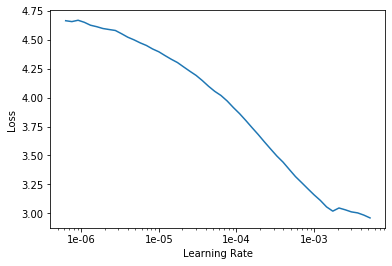

In [0]:
lr_find(learn) # выполняем настройку скорости обучения
learn.recorder.plot()

In [0]:
lr = 3e-3 # выбираем подходящую по графику

In [0]:

learn.fit_one_cycle(10, slice(lr), pct_start=0.9) # обучаем модель

epoch,train_loss,valid_loss,acc_camvid,time
0,1.233183,0.820127,0.805757,01:27
1,0.831678,0.593835,0.841609,01:26
2,0.683655,0.567138,0.845616,01:26
3,0.698506,0.555768,0.854681,01:25
4,0.626648,0.494457,0.869052,01:25
5,0.567709,0.405210,0.889771,01:25
6,1.369098,2.346275,0.331113,01:24
7,1.135280,0.740133,0.815107,01:23
8,0.777004,0.511846,0.866492,01:23
9,0.599895,0.447548,0.874384,01:23


После 10 шагов 1cycle точность модели будет достигнута близко к 90%. В принципе качество довольно неплохое, но хотелось бы побольше.

В стандартном режиме незаморожен только **декодер** (модель, ответственная за итоговый выходной результат на основании входных сжатых данных), а энкодер используется уже в готовом, ранее обученном виде.

In [0]:
learn.save('stage-1')

In [0]:
learn.load('stage-1');

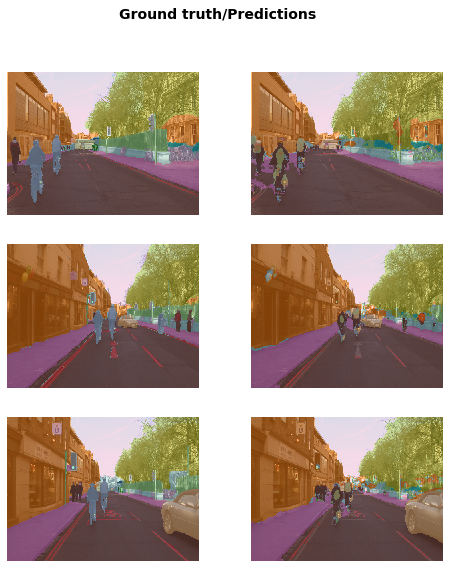

In [0]:
learn.show_results(rows=3, figsize=(8,9)) # смотрим, какие маски получились 

Видно например, что велосипедисты местами путаются с автомобилями и пешеходами.

Что получится, если обучать и входную сеть?

In [0]:
learn.unfreeze() # разморозим всю модель, включая и энкодер

In [0]:
lrs = slice(lr/400,lr/4)

In [0]:
learn.fit_one_cycle(12, lrs, pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.506820,0.441770,0.873790,01:27
1,0.492059,0.430984,0.877864,01:27
2,0.478321,0.419467,0.878364,01:27
3,0.463228,0.376757,0.888404,01:27
4,0.440362,0.387076,0.887085,01:27
5,0.422874,0.341672,0.899803,01:27
6,0.397698,0.339069,0.898515,01:27
7,0.381584,0.330093,0.909553,01:27
8,0.371801,0.318872,0.910855,01:27
9,0.351923,0.291782,0.917228,01:27


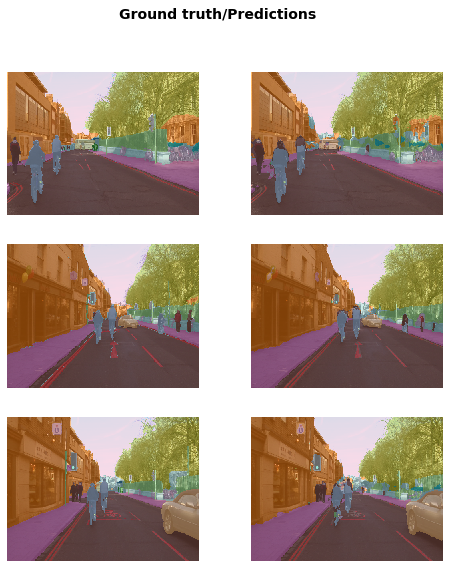

In [0]:
learn.save('stage-2')

learn.show_results(rows=3, figsize=(8,9))

Хотя в процентах разница невелика, но визуально результаты явно получше.

## Берём больше

Сделаем теперь по сути то же самое, только увеличим размер изображений для обучения -- попробуем запихнуть их в графический процессор целиком (в предыдущем примере мы брали уменьшенные вдвое картинки).

In [0]:
learn.destroy()

size = src_size

free = gpu_mem_get_free_no_cache()
if free > 8200: bs=1 
else:           bs=3 # bs на более крупные изображения придётся брать поменьше, возможно даже 2
print(f"получаем bs={bs}, доступно {free}MB из GPU RAM")

In [0]:
# заново прогоним весь цикл обучения
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [0]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

In [0]:
learn.load('stage-2');

In [0]:
lr_find(learn)
learn.recorder.plot()

In [0]:
lr=1e-3 

In [0]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.8) 

epoch,train_loss,valid_loss,acc_camvid,time
0,0.460326,0.353811,0.906002,05:27
1,0.438466,0.363744,0.903433,05:31
2,0.400309,0.346946,0.909524,05:31
3,0.422305,0.349934,0.900177,05:31
4,0.409704,0.387310,0.903627,05:30
5,0.421579,0.375246,0.906108,05:30
6,0.403428,0.363395,0.904613,05:30
7,0.369322,0.309179,0.916426,05:29
8,0.322315,0.252682,0.934624,05:29
9,0.238442,0.266886,0.930581,05:29


In [0]:
learn.save('stage-1-big')

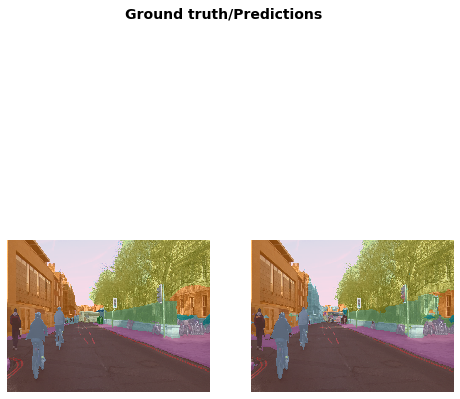

In [0]:
learn.load('stage-1-big')
learn.show_results(rows=3, figsize=(8,9))

Результаты явно лучше.

In [0]:
learn.unfreeze() # и то же самое с разморозкой

In [0]:
lrs = slice(1e-6, lr/10)

In [0]:
learn.fit_one_cycle(10, lrs)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.250582,0.253239,0.934137,05:42
1,0.266594,0.272693,0.929967,05:46
2,0.248332,0.258763,0.931140,05:46
3,0.227952,0.254356,0.935139,05:46
4,0.212447,0.239776,0.935899,05:46
5,0.213564,0.259668,0.931971,05:46
6,0.208390,0.272795,0.928059,05:46
7,0.200561,0.247905,0.935760,05:46
8,0.199371,0.257690,0.931384,05:46
9,0.201726,0.257282,0.932051,05:46


In [0]:
learn.save('stage-2-big')

## Задание

Найдите стандартные датасеты для задачи сегментации изображений (можно погуглить "segmentation dataset"), и проверьте, насколько хорошо будет на них обучаться модель U-NET.

Инструмент для самостоятельного создания подобных датасетов:

https://github.com/abreheret/PixelAnnotationTool